In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
qvi_data = pd.read_csv("QVI_data.csv")
qvi_data['DATE'] = pd.to_datetime(qvi_data['DATE'])
qvi_data['MONTH'] = qvi_data['DATE'].dt.to_period('M')
monthly_data = qvi_data.groupby(['STORE_NBR', 'MONTH']).agg(
    total_sales=('TOT_SALES', 'sum'),
    unique_customers=('LYLTY_CARD_NBR', 'nunique'),
    total_transactions=('TXN_ID', 'count')
).reset_index()

In [7]:
monthly_data['avg_transactions_per_customer'] = (
    monthly_data['total_transactions'] / monthly_data['unique_customers']
)

In [8]:
def find_control_stores(trial_store, metrics, data, month_range):
    trial_data = data[(data['STORE_NBR'] == trial_store) & (data['MONTH'].isin(month_range))]
    control_data = data[(data['STORE_NBR'] != trial_store) & (data['MONTH'].isin(month_range))]
    
    similarity_scores = []
    
    for store in control_data['STORE_NBR'].unique():
        store_data = control_data[control_data['STORE_NBR'] == store]
        
        # Calculate similarity for each metric
        scores = []
        for metric in metrics:
            trial_metric = trial_data[metric].values
            store_metric = store_data[metric].values
            if len(trial_metric) == len(store_metric):  # Ensure same time periods
                corr, _ = pearsonr(trial_metric, store_metric)
                scores.append(corr)
        
        # Average similarity score across metrics
        if scores:
            similarity_scores.append((store, sum(scores) / len(scores)))
    
    # Rank stores by similarity score
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    return similarity_scores

In [9]:
def compare_trial_control(trial_store, control_store, metrics, data, trial_period):
    trial_data = data[(data['STORE_NBR'] == trial_store) & (data['MONTH'].isin(trial_period))]
    control_data = data[(data['STORE_NBR'] == control_store) & (data['MONTH'].isin(trial_period))]

    for metric in metrics:
        plt.figure(figsize=(10, 6))
        plt.plot(trial_data['MONTH'].astype(str), trial_data[metric], label=f'Trial Store {trial_store}', marker='o')
        plt.plot(control_data['MONTH'].astype(str), control_data[metric], label=f'Control Store {control_store}', marker='o')
        plt.title(f'Comparison of {metric} for Trial and Control Stores')
        plt.xlabel('Month')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()

In [10]:
trial_period = ['2018-12', '2019-01', '2019-02']
trial_period = pd.PeriodIndex(trial_period, freq='M')
comparison_metrics = ['total_sales', 'unique_customers']

In [11]:
control_stores_77 = find_control_stores(77, comparison_metrics, monthly_data, trial_period)
control_store_77 = control_stores_77[0][0]
control_stores_86 = find_control_stores(86, comparison_metrics, monthly_data, trial_period)
control_store_86 = control_stores_86[0][0]
control_stores_88 = find_control_stores(88, comparison_metrics, monthly_data, trial_period)
control_store_88 = control_stores_88[0][0]

In [12]:
stores_to_analyze = [
    (77, control_store_77),
    (86, control_store_86),
    (88, control_store_88)
]

Comparing Trial Store 77 with Control Store 236


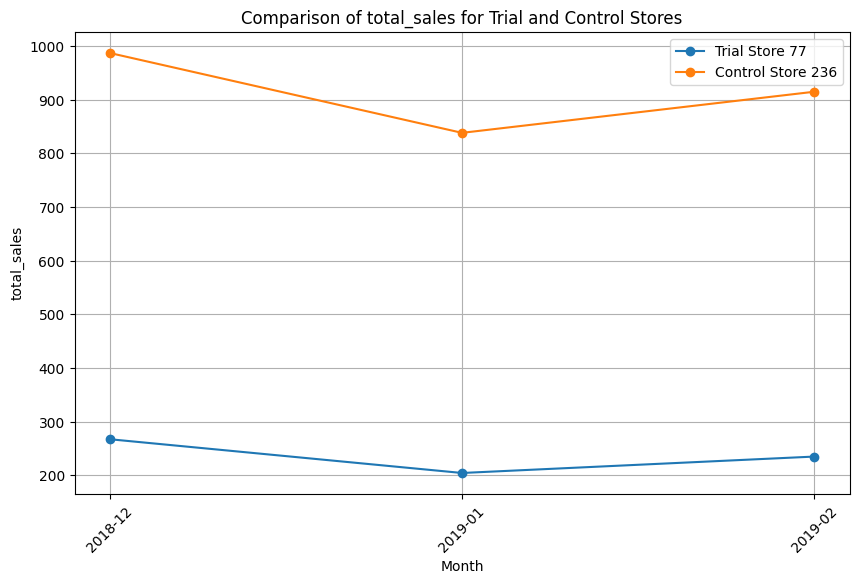

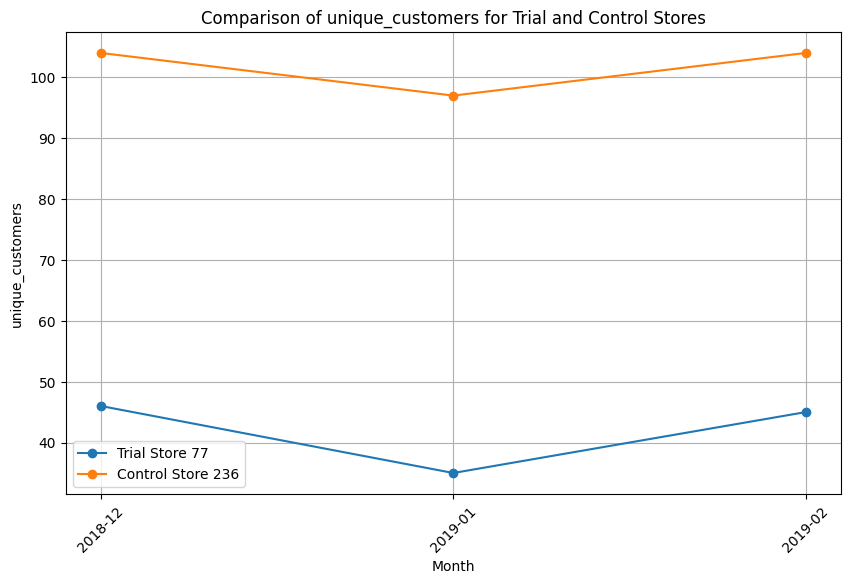

Comparing Trial Store 86 with Control Store 143


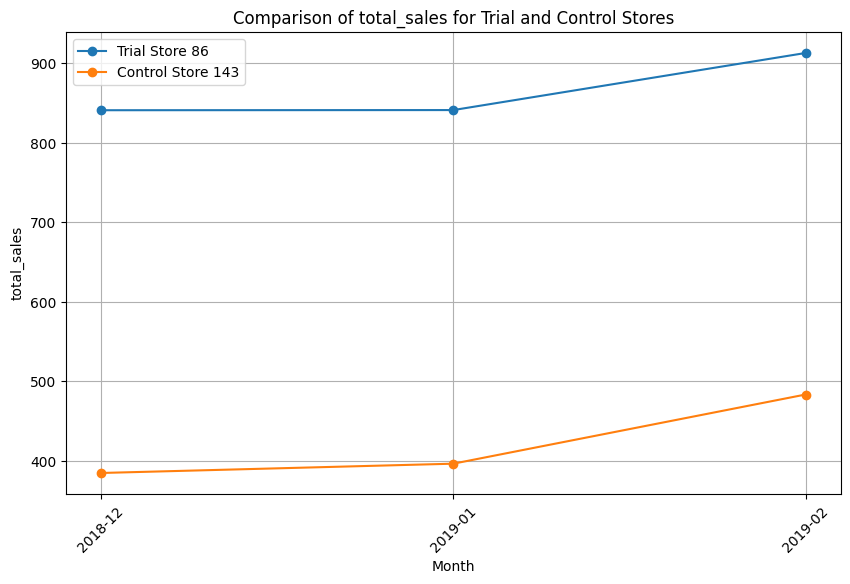

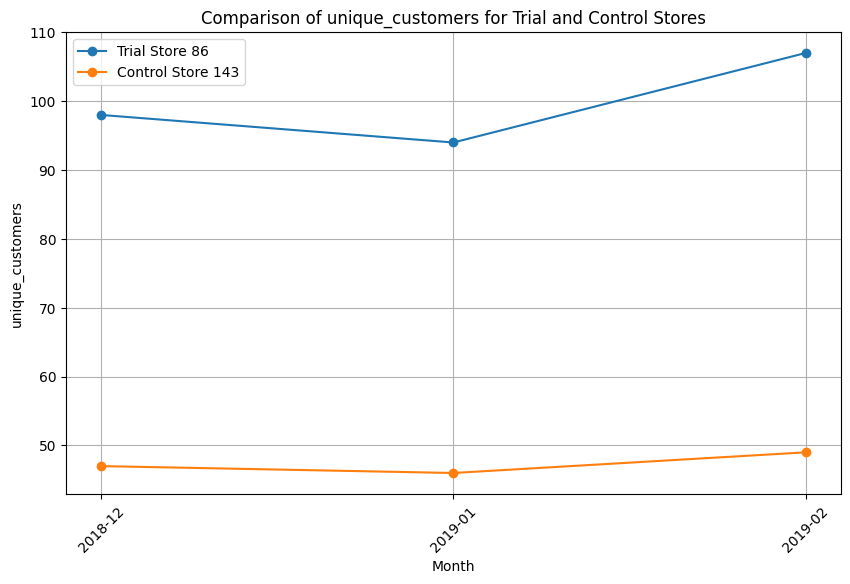

Comparing Trial Store 88 with Control Store 119


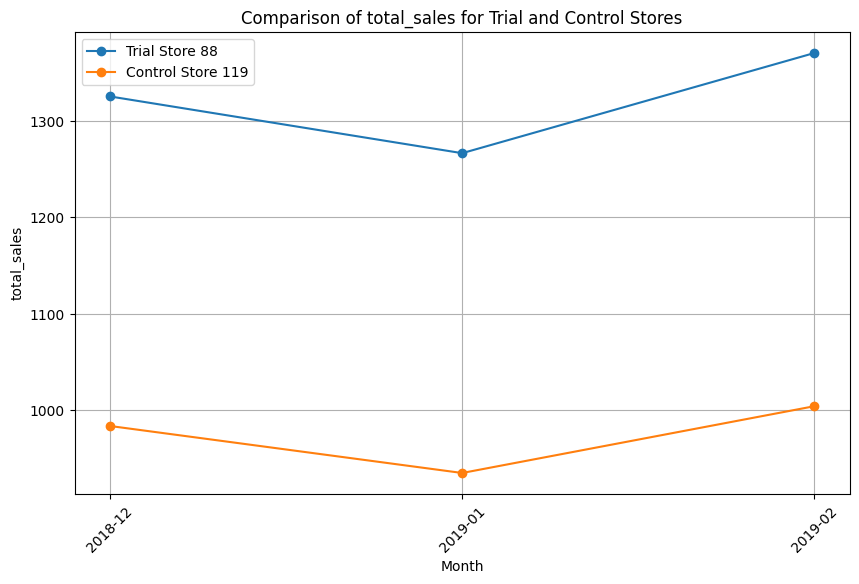

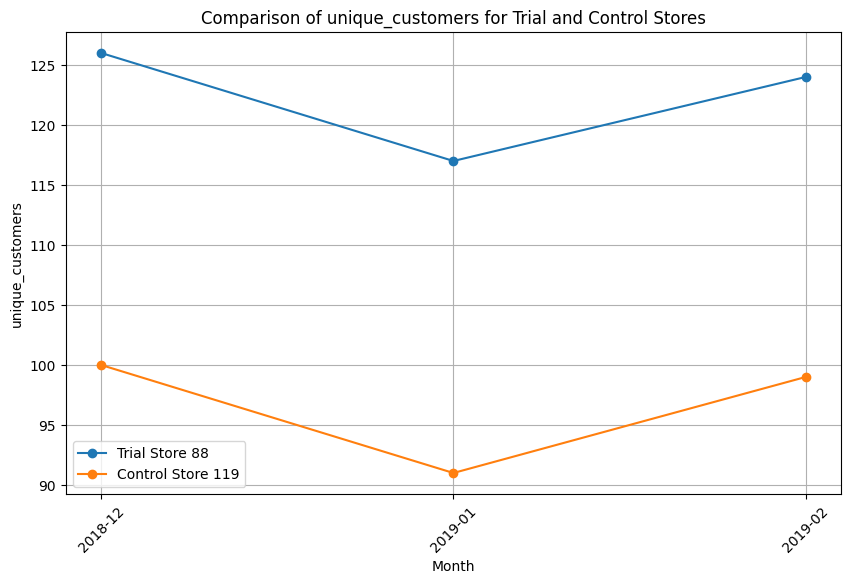

In [13]:
for trial_store, control_store in stores_to_analyze:
    print(f"Comparing Trial Store {trial_store} with Control Store {control_store}")
    compare_trial_control(trial_store, control_store, comparison_metrics, monthly_data, trial_period)